# **FLUXO DE MODELAGEM DE PROJEÇÃO, COM VALIDAÇÃO SIMPLES + CRUZADA**
### *Case: Potencial de Novos Clientes*
---



### **Bibliotecas**

In [2]:
import pandas as pd                                                                # Manipulação de dados
import numpy as np                                                                 # Realização de cálculos específicos
import matplotlib.pyplot as plt                                                    # Visualização de dados 
import seaborn as sns                                                              # Visualização de dados
import time                                                                        # Cálculo de tempo de execução
import math                                                                        # Funções matemáticas
from scipy.stats import randint, uniform, loguniform                               # Geração de valores aleatórios
from sklearn.compose import ColumnTransformer                                      # Transformação de colunas
from sklearn.preprocessing import StandardScaler, OneHotEncoder                    # Transformação de colunas
from sklearn.base import clone                                                     # Criação de cópias de modelos
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV    # Validação simples e validação cruzada
from sklearn.metrics import r2_score, root_mean_squared_error                      # Métricas de avaliação de modelos
from sklearn.linear_model import LinearRegression                                  # Regressão linear
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor            # Regressão linear com regularização
from sklearn.tree import DecisionTreeRegressor                                     # Árvore de regressão
from sklearn.ensemble import RandomForestRegressor                                 # Floresta aleatória
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor          # Impulsionamento tradicional
from sklearn.ensemble import HistGradientBoostingRegressor                         # Impulsionamento com histogramas
from xgboost import XGBRegressor                                                   # Impulsionamento via XGBoost
from lightgbm import LGBMRegressor                                                 # Impulsionamento via LightGBM
from catboost import CatBoostRegressor                                             # Impulsionamento via CatBoost
from sklearn.neighbors import KNeighborsRegressor                                  # K vizinhos mais próximos
from sklearn.inspection import permutation_importance                              # Importância de variáveis por permutação
import shap                                                                        # Interpretabilidade de variáveis nos modelos

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'xgboost'

### **Leitura da base de dados**

In [3]:
dados = pd.read_table("Potencial_Novos_Clientes.txt",
                      sep="\t",
                      header=0)

FileNotFoundError: [Errno 2] No such file or directory: 'Potencial_Novos_Clientes.txt'

### **Visualização da base de dados**

In [333]:
dados.head()

,COD_CARTAO,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M,SATISFACAO_ULTIMA_COMPRA,VALOR_GASTO_PROX_12M
0,212394,22,1500,52,2,4,802,401.000,0,01_Muito_Satisfeito,226
1,279177,29,1800,94,5,5,1384,276.800,1,03_Neutro,2786
2,291430,36,1500,89,5,6,1610,322.000,1,Nao_Respondeu,3737
3,176612,43,1500,48,3,4,836,278.670,0,01_Muito_Satisfeito,1162
4,223092,28,12090,89,4,5,1318,329.500,0,Nao_Respondeu,2699


### **Dimensões da base de dados**

In [334]:
dados.shape

(2930, 11)

### **Tipos das colunas da base de dados**

In [335]:
dados.dtypes

COD_CARTAO                    int64
IDADE_CLIENTE                 int64
RENDA_MENSAL_CLIENTE          int64
BEHAVIOUR_SCORE_CLIENTE       int64
QTD_TRANSACOES_3M             int64
QTD_ITENS_3M                  int64
VALOR_GASTO_3M                int64
TICKET_MEDIO_3M             float64
FLAG_ELETRONICOS_3M           int64
SATISFACAO_ULTIMA_COMPRA     object
VALOR_GASTO_PROX_12M          int64
dtype: object

### **Etapa 1: Especificação de variáveis explicativas e variável resposta**

*Lista de nomes das variáveis explicativas, separando em quantitativas e qualitativas*

In [336]:
# Variáveis explicativas quantitativas (deixar vazio [] caso não haja nenhuma)
lista_X_quanti = ['IDADE_CLIENTE',
                  'RENDA_MENSAL_CLIENTE',
                  'BEHAVIOUR_SCORE_CLIENTE',
                  'QTD_TRANSACOES_3M',
                  'QTD_ITENS_3M',
                  'VALOR_GASTO_3M',
                  'TICKET_MEDIO_3M']

# Variáveis explicativas qualitativas (deixar vazio [] caso não haja nenhuma)
lista_X_quali = ['FLAG_ELETRONICOS_3M',
                 'SATISFACAO_ULTIMA_COMPRA']

In [337]:
y = dados['VALOR_GASTO_PROX_12M']
X = dados[lista_X_quanti + lista_X_quali]

### **Etapa 2: Divisão de treino e teste externo**

In [338]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=123)

### **Etapa 3: Pré-processamento de variáveis explicativas**

*Definição das funções de pré-processamento: Padronização das variáveis quantitativas + Codificação one-hot para variáveis qualitativas*

In [339]:
preprocessador = ColumnTransformer(transformers=[
    ("quanti", StandardScaler(), lista_X_quanti),
    ("quali", OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore'), lista_X_quali)
])

*Criação do pré-processamento no conjunto de treino* <br>

In [340]:
X_treino_tratada = preprocessador.fit_transform(X_treino)  # O pré-processamento não deve envolver o conjunto de teste externo, que deve ficar reservado apenas para aplicações de resultados já obtidos, e nunca construções
if lista_X_quali:
    nomes_quali = list(preprocessador.named_transformers_['quali'].get_feature_names_out(lista_X_quali))
else:
    nomes_quali = []
nomes_variaveis = list(lista_X_quanti) + nomes_quali

In [341]:
X_treino_tratada = pd.DataFrame(X_treino_tratada, columns=nomes_variaveis)
X_treino_tratada.head()

,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M_1,SATISFACAO_ULTIMA_COMPRA_02_Satisfeito,SATISFACAO_ULTIMA_COMPRA_03_Neutro,SATISFACAO_ULTIMA_COMPRA_04_Insatisfeito,SATISFACAO_ULTIMA_COMPRA_05_Muito_Insatisfeito,SATISFACAO_ULTIMA_COMPRA_Nao_Respondeu
0,0.616,0.632,-0.327,-0.082,-0.249,-0.273,-0.401,1.000,1.000,0.000,0.000,0.000,0.000
1,-0.544,0.492,0.939,1.087,-0.249,1.142,-0.338,1.000,0.000,0.000,0.000,0.000,1.000
2,0.181,1.155,0.073,-0.666,0.243,-0.548,-0.018,0.000,0.000,0.000,0.000,0.000,1.000
3,-0.399,0.960,-0.261,0.502,-0.249,-0.964,-1.110,1.000,0.000,0.000,0.000,0.000,0.000
4,-1.487,-0.168,0.073,-0.666,-1.235,-1.017,-0.520,0.000,0.000,0.000,0.000,1.000,0.000


*Aplicação do pré-processamento no conjunto de teste externo*

In [342]:
X_teste_tratada = preprocessador.transform(X_teste)  # Note que o mesmo objeto de pré-processamento deve ser utilizado, agora com 'transform' em vez de 'fit_transform'
X_teste_tratada = pd.DataFrame(X_teste_tratada, columns=nomes_variaveis)
X_teste_tratada.head()

,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M_1,SATISFACAO_ULTIMA_COMPRA_02_Satisfeito,SATISFACAO_ULTIMA_COMPRA_03_Neutro,SATISFACAO_ULTIMA_COMPRA_04_Insatisfeito,SATISFACAO_ULTIMA_COMPRA_05_Muito_Insatisfeito,SATISFACAO_ULTIMA_COMPRA_Nao_Respondeu
0,-0.689,0.366,-0.061,-0.666,-0.249,-1.157,-0.669,0.000,1.000,0.000,0.000,0.000,0.000
1,0.978,1.325,0.606,1.671,0.736,2.223,-0.189,0.000,0.000,0.000,0.000,0.000,1.000
2,1.196,1.427,1.406,1.087,1.228,0.134,-0.769,1.000,0.000,1.000,0.000,0.000,0.000
3,-0.617,0.381,0.673,-0.082,-0.249,0.541,0.179,0.000,0.000,1.000,0.000,0.000,0.000
4,-0.979,-0.062,-1.327,1.087,-0.742,0.046,-0.807,0.000,0.000,0.000,0.000,0.000,0.000


### **Etapa 4: Definição dos algoritmos e intervalos de busca de hiperparâmetros**

In [343]:
algoritmos = {

    'REGRESSÃO LINEAR': (LinearRegression(), {
    }),
    
    'REGRESSÃO LINEAR + RIDGE': (Ridge(), {
        'alpha': loguniform(1e-5, 1e1)                # Força da penalização L2: valores menores são mais prováveis
    }),

    'REGRESSÃO LINEAR + LASSO': (Lasso(random_state=123, max_iter=1000), {
        'alpha': loguniform(1e-5, 1e1)                # Força da penalização L1: favorece esparsidade
    }),

    'REGRESSÃO LINEAR + ELASTICNET': (ElasticNet(random_state=123, max_iter=1000), {
        'alpha': loguniform(1e-5, 1e1),               # Força global da penalização
        "l1_ratio": uniform(0, 1)                     # Proporção de L1: 0 = ridge puro, 1 = LASSO puro
    }),

    'REGRESSÃO LINEAR VIA GRADIENTE DESCENDENTE': (SGDRegressor(random_state=123, max_iter=10000, tol=1e-3), {
        'penalty': ['l2', 'l1', 'elasticnet'],        # Tipo de penalização
        "alpha": loguniform(1e-5, 1e1),               # Força da regularização
        "l1_ratio": uniform(0, 1),                    # Proporção L1 no caso elasticnet
        "eta0": loguniform(1e-4, 1e-1),               # Taxa inicial de aprendizado
        "learning_rate": ["constant", "invscaling", "adaptive"]  # Estratégia de atualização do eta0
    }),

    'ÁRVORE DE REGRESSÃO': (DecisionTreeRegressor(random_state=123), {
        'max_depth': randint(3, 11),                  # Profundidade máxima da árvore
        'min_samples_split': randint(2, 11),          # Qtde. mínimo de amostras para dividir um nó
        'min_samples_leaf': randint(1, 6)             # Qtde. mínimo de amostras em uma folha
    }),

    'FLORESTA ALEATÓRIA': (RandomForestRegressor(random_state=123, n_jobs = -1), {
        'n_estimators': randint(100, 501),            # Qtde. de árvores na floresta
        'max_depth': randint(3, 11),                  # Profundidade máxima das árvores
        'min_samples_split': randint(2, 11),          # Critério de divisão mínima
        'min_samples_leaf': randint(1, 6),            # Tamanho mínimo de folha
        'bootstrap': [True, False],                   # Amostragem com ou sem reposição
        'max_features': ['sqrt', 'log2', None]        # Qtde. de variáveis por split
    }),

    'ADABOOST': (AdaBoostRegressor(random_state=123), {
        'n_estimators': randint(50, 301),             # Qtde. de estimadores fracos
        'learning_rate': uniform(0.01, 0.99)          # Peso aplicado a cada novo estimador
    }),

    'GRADIENT BOOSTING': (GradientBoostingRegressor(random_state=123), {
        'n_estimators': randint(100, 301),            # Qtde. de árvores no boosting
        'learning_rate': uniform(0.01, 0.29),         # Taxa de aprendizado
        'max_depth': randint(3, 11),                  # Profundidade máxima das árvores
        'min_samples_split': randint(2, 11),          # Tamanho mínimo de split
        'min_samples_leaf': randint(1, 6),            # Tamanho mínimo de folha
        'subsample': uniform(0.6, 0.4),               # Proporção da amostra usada em cada árvore
        'max_features': ['sqrt', 'log2', None]        # Qtde. de variáveis por split
    }),

    'HISTGRADIENTBOOSTING': (HistGradientBoostingRegressor(random_state=123), {
        'learning_rate': uniform(0.01, 0.29),         # Taxa de aprendizado
        'max_iter': randint(100, 301),                # Qtde. de iterações (árvores)
        'max_depth': randint(3, 11),                  # Profundidade máxima
        'min_samples_leaf': randint(1, 6),            # Tamanho mínimo de folha
        'max_bins': randint(128, 257),                # Qtde. de bins para discretização
        'l2_regularization': uniform(0.0, 1.0),       # Penalização L2
        'max_leaf_nodes': randint(15, 100)            # Máximo de folhas por árvore
    }),

    'XGBOOST': (XGBRegressor(random_state=123, n_jobs = -1), {
        'n_estimators': randint(100, 301),            # Qtde. de árvores
        'learning_rate': uniform(0.01, 0.29),         # Taxa de aprendizado
        'max_depth': randint(3, 11),                  # Profundidade máxima
        'subsample': uniform(0.5, 0.5),               # Proporção da amostra
        'colsample_bytree': uniform(0.5, 0.5),        # Proporção de variáveis por árvore
        'gamma': uniform(0, 5),                       # Redução mínima de perda para quebrar
        'reg_alpha': uniform(0, 1),                   # Penalização L1
        'reg_lambda': uniform(0, 1)                   # Penalização L2
    }),

    'LIGHTGBM': (LGBMRegressor(random_state=123, n_jobs = -1, verbosity=-1), {
        'n_estimators': randint(100, 301),            # Qtde. de árvores
        'learning_rate': uniform(0.01, 0.29),         # Taxa de aprendizado
        'max_depth': randint(3, 11),                  # Profundidade máxima
        'num_leaves': randint(20, 150),               # Qtde. máximo de folhas
        'subsample': uniform(0.5, 0.5),               # Proporção da amostra
        'reg_alpha': uniform(0, 1),                   # Penalização L1
        'reg_lambda': uniform(0, 1),                  # Penalização L2
        'min_child_samples': randint(5, 50)           # Mínimo de amostras por folha
    }),

    'CATBOOST': (CatBoostRegressor(random_state=123, verbose=0), {
        'iterations': randint(100, 301),              # Qtde. de árvores (iterações)
        'learning_rate': uniform(0.01, 0.29),         # Taxa de aprendizado
        'depth': randint(3, 11),                      # Profundidade máxima
        'l2_leaf_reg': uniform(1, 9),                 # Penalização L2
        'subsample': uniform(0.6, 0.4)                # Proporção da amostra
    }),

    'KNN': (KNeighborsRegressor(n_jobs = -1), {
        'n_neighbors': randint(3, 51),                # Qtde. de vizinhos
        'weights': ['uniform', 'distance'],           # Tipo de ponderação
        'p': [1, 2]                                   # Distância: 1 = manhattan, 2 = euclidiana
    })
}

### **Etapa 5: Construção de modelos usando validação cruzada, busca aleatória e teste externo**

*Estratégia de validação cruzada (k-fold) e quantidade máxima de iterações de busca*

In [344]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
qtd_iteracoes = 20

*Construção dos modelos*

In [345]:
resultados = []         # Lista para armazenar resultados
contador_modelos = 0    # Contador de modelos testados

for nome_algoritmo, (classe_algoritmo, hiperparametros) in algoritmos.items():

    # Início da contagem de tempo e de modelos
    inicio = time.time()

    # Busca aleatória de hiperparâmetros com validação cruzada (randomized search)
    busca = RandomizedSearchCV(
        estimator=classe_algoritmo,
        param_distributions=hiperparametros,
        n_iter=1 if not hiperparametros else qtd_iteracoes,
        scoring='neg_mean_absolute_error',
        cv=kf,
        return_train_score=True,
        random_state=123,
        n_jobs=-1
    )

    # Ajuste dos modelos
    busca.fit(X_treino_tratada, y_treino)

    # Armazenar os resultados da busca
    resultados_aux = pd.DataFrame({
        "num_modelo": [f"Modelo {contador_modelos + i}" for i in range(len(busca.cv_results_["params"]))],
        "nome_algoritmo": nome_algoritmo,
        "classe_algoritmo": type(classe_algoritmo).__name__,
        "hiperparametros": busca.cv_results_["params"],
        "media_erro_treino": -busca.cv_results_["mean_train_score"],
        "media_erro_teste_interno": -busca.cv_results_["mean_test_score"],
        "dp_erro_treino": busca.cv_results_["std_train_score"],
        "dp_erro_teste_interno": busca.cv_results_["std_test_score"]
    })

    # Calcular erro no teste externo, para cada modelo
    erro_teste = []
    for params in resultados_aux["hiperparametros"]:
        estimador = clone(classe_algoritmo).set_params(**params)
        estimador.fit(X_treino_tratada, y_treino)
        y_hat_teste = estimador.predict(X_teste_tratada)
        erro = root_mean_squared_error(y_teste, y_hat_teste)
        erro_teste.append(erro)

    # Adicionar coluna de erro em teste externo e colunas de variações absolutas de erro em relação ao treino
    resultados_aux["erro_teste_externo"] = erro_teste
    resultados_aux["var_abs_media_erro_teste_interno"] = abs(resultados_aux["media_erro_teste_interno"] - resultados_aux["media_erro_treino"])
    resultados_aux["var_abs_perc_media_erro_teste_interno"] = resultados_aux["var_abs_media_erro_teste_interno"] / resultados_aux["media_erro_treino"]
    resultados_aux["var_abs_erro_teste_externo"] = abs(resultados_aux["erro_teste_externo"] - resultados_aux["media_erro_treino"])
    resultados_aux["var_abs_perc_erro_teste_externo"] = resultados_aux["var_abs_erro_teste_externo"] / resultados_aux["media_erro_treino"]

    resultados.append(resultados_aux)
    contador_modelos += len(resultados_aux)

    # Fim da contagem de tempo e mensagem de finalização
    fim = time.time()
    print(f"({math.ceil(contador_modelos/qtd_iteracoes)} de {len(algoritmos)}) Processo concluído para o algoritmo {nome_algoritmo} em {fim - inicio:.1f} segundos!")

# Criação de data frame com os resultados
resultados = pd.concat(resultados, ignore_index=True)

(1 de 14) Processo concluído para o algoritmo REGRESSÃO LINEAR em 6.0 segundos!
(2 de 14) Processo concluído para o algoritmo REGRESSÃO LINEAR + RIDGE em 5.2 segundos!
(3 de 14) Processo concluído para o algoritmo REGRESSÃO LINEAR + LASSO em 0.5 segundos!
(4 de 14) Processo concluído para o algoritmo REGRESSÃO LINEAR + ELASTICNET em 0.5 segundos!


c:\Users\angel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\angel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\angel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\angel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

(5 de 14) Processo concluído para o algoritmo REGRESSÃO LINEAR VIA GRADIENTE DESCENDENTE em 27.1 segundos!
(6 de 14) Processo concluído para o algoritmo ÁRVORE DE REGRESSÃO em 0.9 segundos!
(7 de 14) Processo concluído para o algoritmo FLORESTA ALEATÓRIA em 58.6 segundos!
(8 de 14) Processo concluído para o algoritmo ADABOOST em 26.7 segundos!
(9 de 14) Processo concluído para o algoritmo GRADIENT BOOSTING em 33.8 segundos!
(10 de 14) Processo concluído para o algoritmo HISTGRADIENTBOOSTING em 41.1 segundos!
(11 de 14) Processo concluído para o algoritmo XGBOOST em 21.6 segundos!
(12 de 14) Processo concluído para o algoritmo LIGHTGBM em 14.8 segundos!
(13 de 14) Processo concluído para o algoritmo CATBOOST em 58.7 segundos!
(14 de 14) Processo concluído para o algoritmo KNN em 5.9 segundos!


### **Etapa 6: Comparação de modelos**

*Gráficos de resumo dos algoritmos*

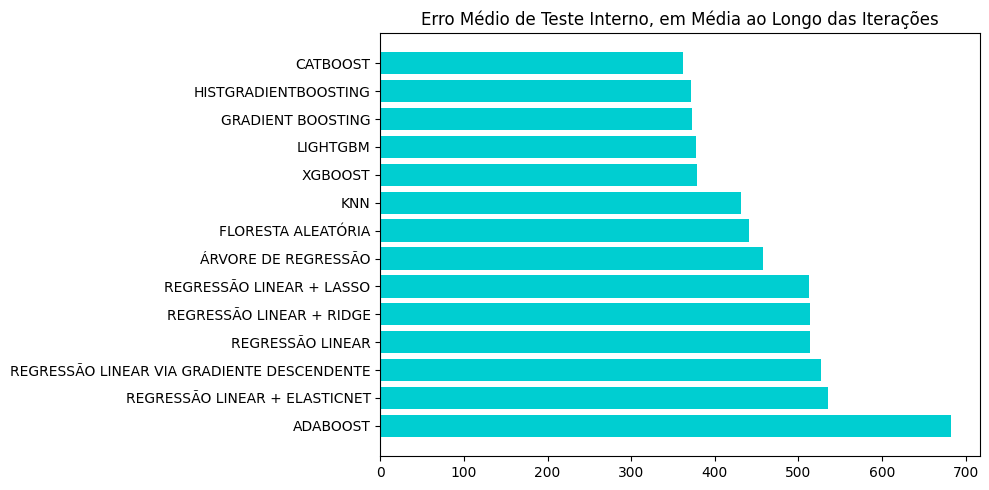

In [346]:
# Gráfico do erro médio nos conjuntos de teste interno, em média ao longo das iterações do randomized search
resumo_algoritmos = (
    resultados
    .groupby("nome_algoritmo")["media_erro_teste_interno"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
plt.barh(resumo_algoritmos.index, resumo_algoritmos.values, color="darkturquoise")
plt.title("Erro Médio de Teste Interno, em Média ao Longo das Iterações")
plt.tight_layout()
plt.show()

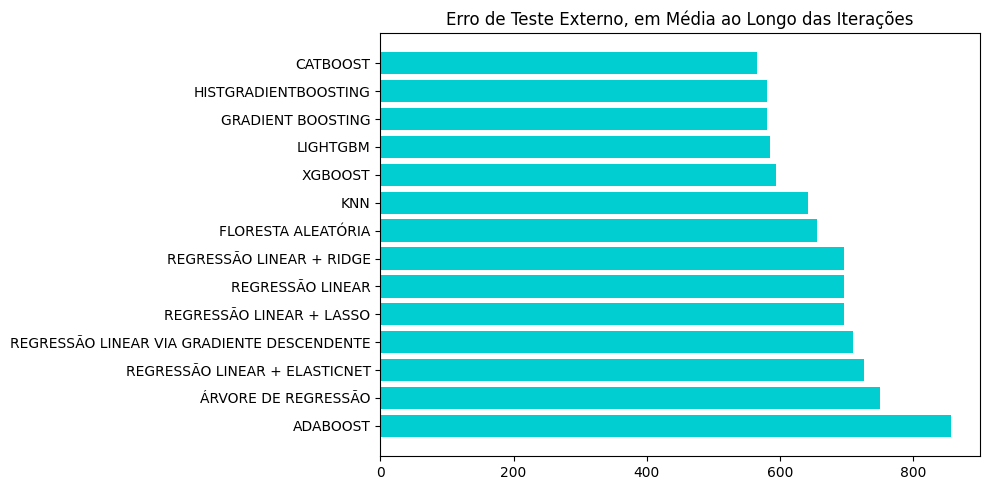

In [347]:
# Gráfico do erro no conjunto de teste externo, em média ao longo das iterações do randomized search
resumo_algoritmos = (
    resultados
    .groupby("nome_algoritmo")["erro_teste_externo"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
plt.barh(resumo_algoritmos.index, resumo_algoritmos.values, color="darkturquoise")
plt.title("Erro de Teste Externo, em Média ao Longo das Iterações")
plt.tight_layout()
plt.show()

*Ordenação e filtragem dos melhores modelos*

In [381]:
# Escolha por qual coluna ordenar
ordenar_por = "media_erro_teste_interno"
# ordenar_por = "var_abs_media_erro_teste_interno"
# ordenar_por = "var_abs_erro_teste_externo"

# Escolha quais o percentuais máximos de variação de erro (da média do treino para a média do teste interno; e da média do treino para o teste externo)
max_var_perc_erro_teste_interno = 0.1
max_var_perc_erro_teste_externo = 0.3

# Ordenação e filtragem
resultados_filt_ord = resultados[(resultados['var_abs_perc_media_erro_teste_interno'] < max_var_perc_erro_teste_interno) & (resultados['var_abs_perc_erro_teste_externo'] < max_var_perc_erro_teste_externo)]
resultados_filt_ord = resultados_filt_ord.sort_values(ordenar_por, ascending=True)

*Exibição dos melhores modelos, em formato de tabela e gráfico*

In [382]:
pd.set_option('display.float_format', '{:.3f}'.format)   # Quantidade de casas decimais
resultados_filt_ord[['num_modelo',
                     'nome_algoritmo',
                     'media_erro_treino',
                     'dp_erro_treino',
                     'media_erro_teste_interno',
                     'dp_erro_teste_interno',
                     'var_abs_media_erro_teste_interno',
                     'var_abs_perc_media_erro_teste_interno',
                     'erro_teste_externo',
                     'var_abs_erro_teste_externo',
                     'var_abs_perc_erro_teste_externo']].head(10)   # Escolha quantos modelos quer exibir

,num_modelo,nome_algoritmo,media_erro_treino,dp_erro_treino,media_erro_teste_interno,dp_erro_teste_interno,var_abs_media_erro_teste_interno,var_abs_perc_media_erro_teste_interno,erro_teste_externo,var_abs_erro_teste_externo,var_abs_perc_erro_teste_externo
80,Modelo 80,REGRESSÃO LINEAR VIA GRADIENTE DESCENDENTE,584.324,162.612,605.757,186.591,21.433,0.037,733.153,148.829,0.255
78,Modelo 78,REGRESSÃO LINEAR VIA GRADIENTE DESCENDENTE,608.570,209.386,633.151,240.181,24.581,0.040,731.988,123.418,0.203
126,Modelo 126,ADABOOST,653.121,24.631,690.871,27.089,37.749,0.058,842.661,189.540,0.290
138,Modelo 138,ADABOOST,656.012,35.004,696.158,34.600,40.147,0.061,851.987,195.976,0.299
134,Modelo 134,ADABOOST,662.234,67.853,700.913,64.732,38.678,0.058,770.299,108.065,0.163
136,Modelo 136,ADABOOST,676.244,46.302,711.109,33.757,34.865,0.052,868.013,191.769,0.284
125,Modelo 125,ADABOOST,686.092,41.142,724.937,45.636,38.845,0.057,881.181,195.088,0.284
131,Modelo 131,ADABOOST,688.381,39.355,729.024,37.090,40.643,0.059,855.725,167.344,0.243


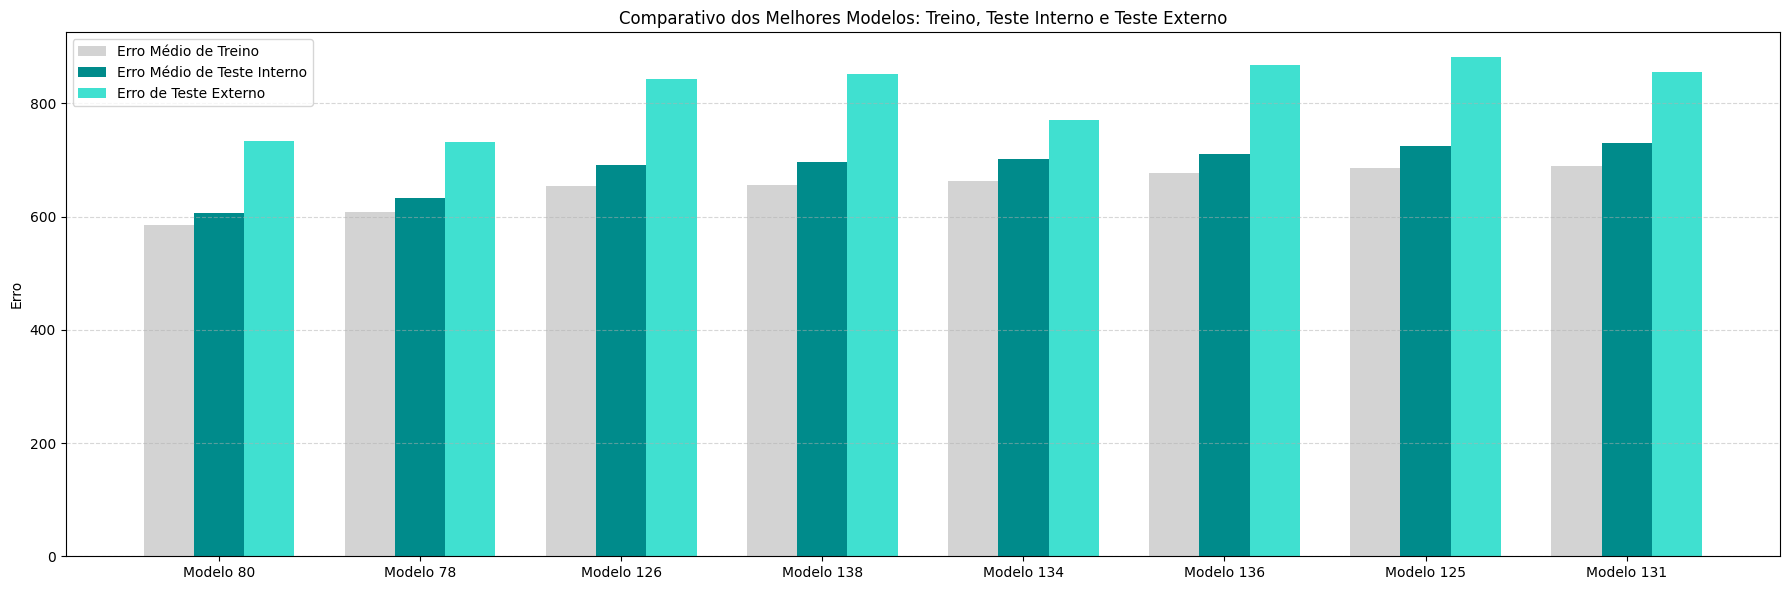

In [383]:
dados_grafico = resultados_filt_ord.head(15)    # Escolha quantos modelos quer exibir
x_pos = np.arange(len(dados_grafico))           # Posições dos rótulos do eixo X
largura_barra = 0.25                            # Largura das barras

plt.figure(figsize=(18, 6))
plt.bar(x_pos - largura_barra,                  # Série com erro médio de treino
        dados_grafico["media_erro_treino"],
        width=largura_barra,
        label="Erro Médio de Treino",
        color="lightgray")
plt.bar(x_pos,                                  # Série com erro médio de teste interno
        dados_grafico["media_erro_teste_interno"],
        width=largura_barra,
        label="Erro Médio de Teste Interno",
        color="darkcyan")
plt.bar(x_pos + largura_barra,                  # Série com erro médio de teste externo
        dados_grafico["erro_teste_externo"],
        width=largura_barra,
        label="Erro de Teste Externo",
        color="turquoise")

plt.xticks(x_pos,
           dados_grafico["num_modelo"],
           rotation=0,
           ha='center')
plt.ylabel("Erro")
plt.title("Comparativo dos Melhores Modelos: Treino, Teste Interno e Teste Externo")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### **Etapa 7: Escolha do modelo**

*Escolha do modelo*

In [386]:
num_modelo_escolhido = "Modelo 80"

*Características do modelo escolhido*

In [387]:
linha = resultados.loc[resultados["num_modelo"] == num_modelo_escolhido].squeeze()
nome_algoritmo = linha["nome_algoritmo"]
hiperparametros = linha["hiperparametros"]
classe = algoritmos[nome_algoritmo][0]
print(f"O modelo final adotado foi construído com o algoritmo {nome_algoritmo}, com hiperparâmetros: { {k: round(v, 4) if isinstance(v, float) else v for k, v in hiperparametros.items()} }")

O modelo final adotado foi construído com o algoritmo REGRESSÃO LINEAR VIA GRADIENTE DESCENDENTE, com hiperparâmetros: {'alpha': np.float64(0.0008), 'eta0': np.float64(0.0119), 'l1_ratio': np.float64(0.5544), 'learning_rate': 'constant', 'penalty': 'elasticnet'}


*Retreino do modelo no conjunto de treino completo*

In [388]:
modelo_final = classe.set_params(**hiperparametros)
modelo_final.fit(X_treino_tratada, y_treino)

,loss,'squared_error'
,penalty,'elasticnet'
,alpha,np.float64(0....7085867368811)
,l1_ratio,np.float64(0.5543832497177721)
,fit_intercept,True
,max_iter,10000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,123


*Coeficientes do modelo*

In [389]:
pd.DataFrame({
    'NOME_VARIAVEL': modelo_final.feature_names_in_,
    'COEF_ESTIMADO': modelo_final.coef_,
    'COEF_ESTIMADO_ABS': np.abs(modelo_final.coef_)
}).sort_values(by='COEF_ESTIMADO_ABS', ascending=False)

,NOME_VARIAVEL,COEF_ESTIMADO,COEF_ESTIMADO_ABS
3,QTD_TRANSACOES_3M,1348.576,1348.576
5,VALOR_GASTO_3M,370.511,370.511
1,RENDA_MENSAL_CLIENTE,364.521,364.521
6,TICKET_MEDIO_3M,357.195,357.195
11,SATISFACAO_ULTIMA_COMPRA_05_Muito_Insatisfeito,-245.896,245.896
7,FLAG_ELETRONICOS_3M_1,209.690,209.690
4,QTD_ITENS_3M,178.961,178.961
10,SATISFACAO_ULTIMA_COMPRA_04_Insatisfeito,-154.730,154.730
12,SATISFACAO_ULTIMA_COMPRA_Nao_Respondeu,-147.443,147.443
0,IDADE_CLIENTE,132.062,132.062


### **Etapa 8: Análises adicionais no conjunto de teste externo**

*Aplicação do modelo final no conjunto de teste externo*

In [390]:
y_hat_teste = modelo_final.predict(X_teste_tratada)

*Coeficiente de determinação ajustado (R²)*

In [391]:
r2 = r2_score(y_teste, y_hat_teste)
p = np.sum(modelo_final.coef_ != 0)
1 - (1 - r2) * (len(y_teste) - 1) / (len(y_teste) - p - 1)

np.float64(0.8262238193596715)

*Erro absoluto médio (MAE)*

In [392]:
np.mean(np.abs(y_teste - y_hat_teste))

np.float64(546.1562234543733)

*Erro absoluto percentual médio (MAPE)*

In [393]:
np.mean(np.abs((y_teste - y_hat_teste) / y))

np.float64(inf)

*Erro quadrático médio em raiz (RMSE)*

In [394]:
np.sqrt(np.mean((y_teste - y_hat_teste)**2))

np.float64(733.1534660969104)

*Resíduos do modelo (e)*

In [395]:
resid = y_teste - y_hat_teste

*Histograma dos resíduos*

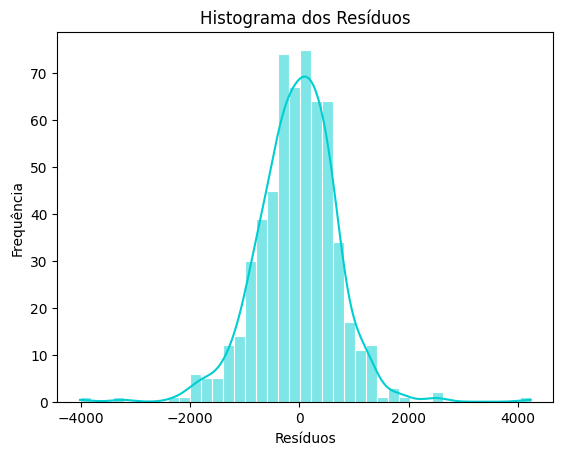

In [396]:
sns.histplot(resid,
             color="darkturquoise",
             edgecolor="white",
             kde=True)
plt.title("Histograma dos Resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.show()

*Gráfico de resíduos vs. valores preditos*

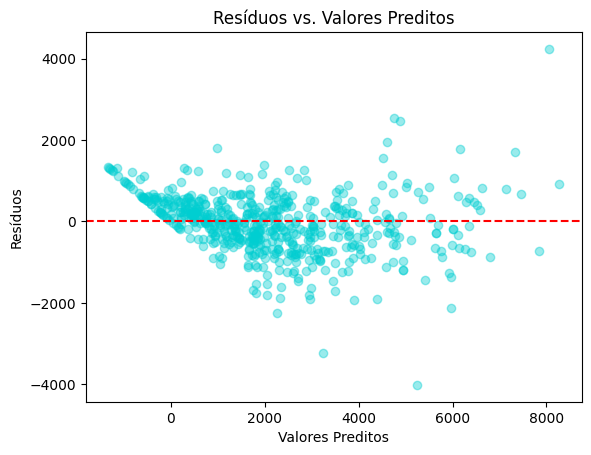

In [397]:
plt.scatter(y_hat_teste,
            resid,
            color="darkturquoise",
            alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs. Valores Preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.show()

*Gráfico de valores observados vs. valores preditos da resposta*

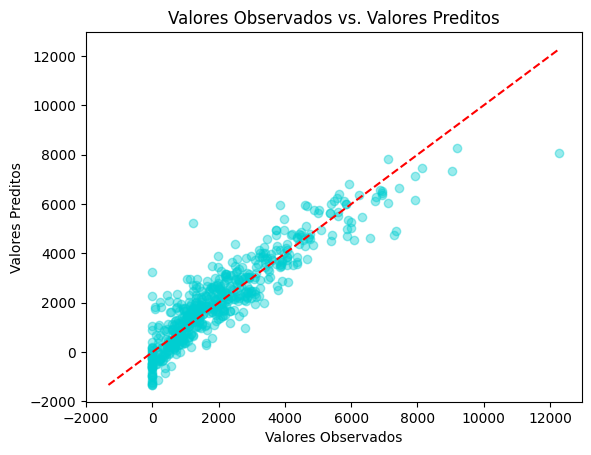

In [398]:
min_eixo = min(y_teste.min(), y_hat_teste.min())
max_eixo = max(y_teste.max(), y_hat_teste.max())
plt.scatter(y_teste,
            y_hat_teste,
            color="darkturquoise",
            alpha=0.4)
plt.plot([min_eixo, max_eixo], [min_eixo, max_eixo], color='red', linestyle='--')
plt.title("Valores Observados vs. Valores Preditos")
plt.xlabel("Valores Observados")
plt.ylabel("Valores Preditos")
plt.show()

### **Etapa 9: Interpretabilidade do modelo final**

*Cálculo da importância individual das variáveis no modelo final, via método de permutação*

In [399]:
importancias = permutation_importance(modelo_final,
                                      X_treino_tratada,
                                      y_treino,
                                      n_repeats=30,
                                      random_state=0, 
                                      scoring='neg_root_mean_squared_error')
importancias = pd.Series(importancias.importances_mean,
                         index=X_treino_tratada.columns).sort_values()

*Gráfico de importâncias, via método de permutação*

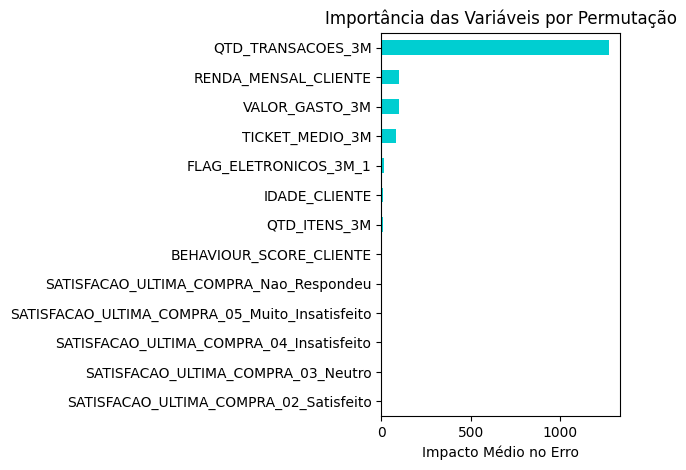

In [400]:
importancias.plot.barh(title="Importância das Variáveis por Permutação",
                       color="darkturquoise")
plt.xlabel("Impacto Médio no Erro")
plt.tight_layout()
plt.show()

*Interpretabilidade dos efeitos das variáveis no modelo final, via método SHAP*

In [401]:
if nome_algoritmo not in ['ADABOOST']:
    explainer = shap.Explainer(modelo_final, X_treino_tratada)
    valores_shap = explainer(X_treino_tratada)
else:
    # Para o AdaBoost, a implementação do cálculo de valores SHAP não é direta; é preciso usar um método computacionalmente oneroso em uma amostra pequena de observações
    X_amostra = shap.sample(X_treino_tratada, 100, random_state=123)
    explainer = shap.KernelExplainer(modelo_final.predict, X_amostra)
    valores_shap = explainer.shap_values(X_amostra)

*Gráfico de valores SHAP (beeswarm)*

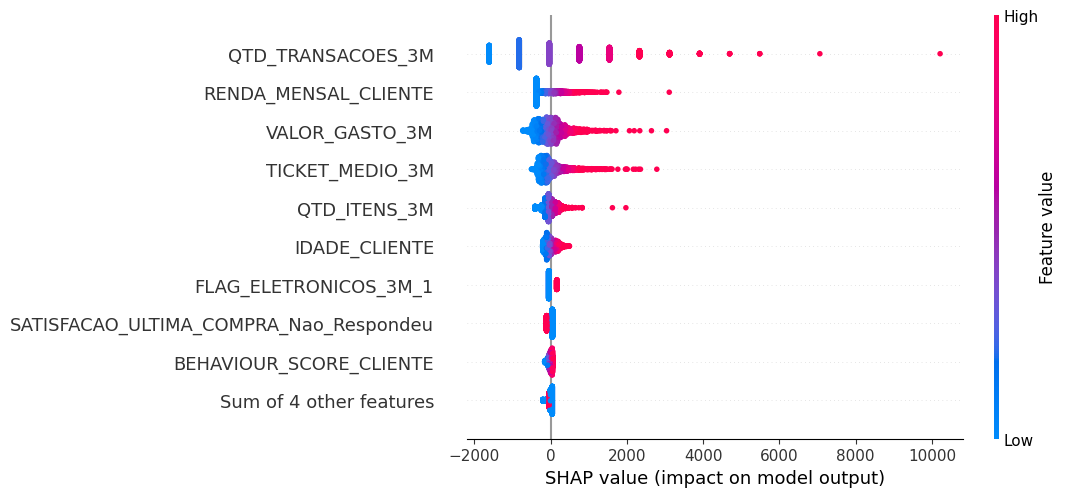

In [402]:
if nome_algoritmo not in ['ADABOOST']:
    shap.plots.beeswarm(valores_shap)
else:
    shap.summary_plot(valores_shap, X_amostra)

### **Etapa 10: Utilização do modelo em nova base de dados**

*Leitura da nova base de dados*

In [403]:
# Considerando a própria base de construção, mas pode ser substituída por uma nova, se houver
dados_novos = pd.read_table("Potencial_Novos_Clientes.txt",
                            sep="\t",
                            header=0)

*Verificação de compatibilidade de nomes e tipos das variáveis, em relação à base de construção*

In [404]:
# Comparação de nomes
dados.columns == dados_novos.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [405]:
# Comparação de tipos
dados.dtypes == dados_novos.dtypes

COD_CARTAO                  True
IDADE_CLIENTE               True
RENDA_MENSAL_CLIENTE        True
BEHAVIOUR_SCORE_CLIENTE     True
QTD_TRANSACOES_3M           True
QTD_ITENS_3M                True
VALOR_GASTO_3M              True
TICKET_MEDIO_3M             True
FLAG_ELETRONICOS_3M         True
SATISFACAO_ULTIMA_COMPRA    True
VALOR_GASTO_PROX_12M        True
dtype: bool

*Criação de objetos y e X*

In [406]:
y_nova = dados['VALOR_GASTO_PROX_12M']
X_nova = dados[lista_X_quanti + lista_X_quali]

*Aplicação do pré-processamento e criação de matriz X tratada*

In [407]:
X_tratada_nova = preprocessador.transform(X)  # Note que o mesmo objeto de pré-processamento deve ser utilizado, agora com 'transform' em vez de 'fit_transform'
X_tratada_nova = pd.DataFrame(X_tratada_nova, columns=nomes_variaveis)

*Aplicação do modelo final na nova base de dados*

In [408]:
y_hat_nova = modelo_final.predict(X_tratada_nova)